# CSI5155 Assignemnt 2
<br>Thomas Sloan tsloa055@uottawa.ca 300437450
<br>
## Table of Contents:


In [258]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import shap



## Import the data
The data is imported here. I also renamed many of the column names (excl. age, sex) because I didn't like their label. The new labels are from the explanation document where they explain what each label is, with the first letter capatilzed and the name only shorted for common aconyms.

In [259]:
df=pd.read_csv("./heart.csv")
df.rename(columns={'cp': 'ChestPainType', 
                   'trtbps': 'RestingBP',
                   'chol':'Cholesterol',
                   'fbs':'FastingBS',
                   'restecg':'RestingECG',
                   'thalachh':'MaxHR',
                   'exng':'ExerciseAngina',
                   'oldpeak':'OldPeak',
                   'thall':'Thalium',
                   'slp':'Slope',
                   'caa':'MajorBloodVessels'}, inplace=True)
df.head()

,age,sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,OldPeak,Slope,MajorBloodVessels,Thalium,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Preprocessing
No label encoding is done because the values are all numerical. 
No Imputation is required since there are no null/missing values found.
No Scaling is done because this is a tree and it isn't distance based, so it shouldn't matter.
No outliers are removed because there didn't seem to be any completely unreasonable values. I considered removing the maximum value for cholesterol, which is over 500 when the average is 246 and a 51 std. I didn't end up removing it because I found articles online talking about having even higher cholesteral. 
<br> <br>
I plot out the values in each column on a graph with the kernel density estimate set to true. This is done to get a visual demostration of the print outs. On the cholesteral plot you can see that 500 is a very high value, but I left it there.

Types of each column
age                    int64
sex                    int64
ChestPainType          int64
RestingBP              int64
Cholesterol            int64
FastingBS              int64
RestingECG             int64
MaxHR                  int64
ExerciseAngina         int64
OldPeak              float64
Slope                  int64
MajorBloodVessels      int64
Thalium                int64
output                 int64
dtype: object


Shape of the dataset
                   count        mean        std    min    25%    50%    75%  \
age                303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   
sex                303.0    0.683168   0.466011    0.0    0.0    1.0    1.0   
ChestPainType      303.0    0.966997   1.032052    0.0    0.0    1.0    2.0   
RestingBP          303.0  131.623762  17.538143   94.0  120.0  130.0  140.0   
Cholesterol        303.0  246.264026  51.830751  126.0  211.0  240.0  274.5   
FastingBS          303.0    0.148515   0.356198    0.0    0.0 

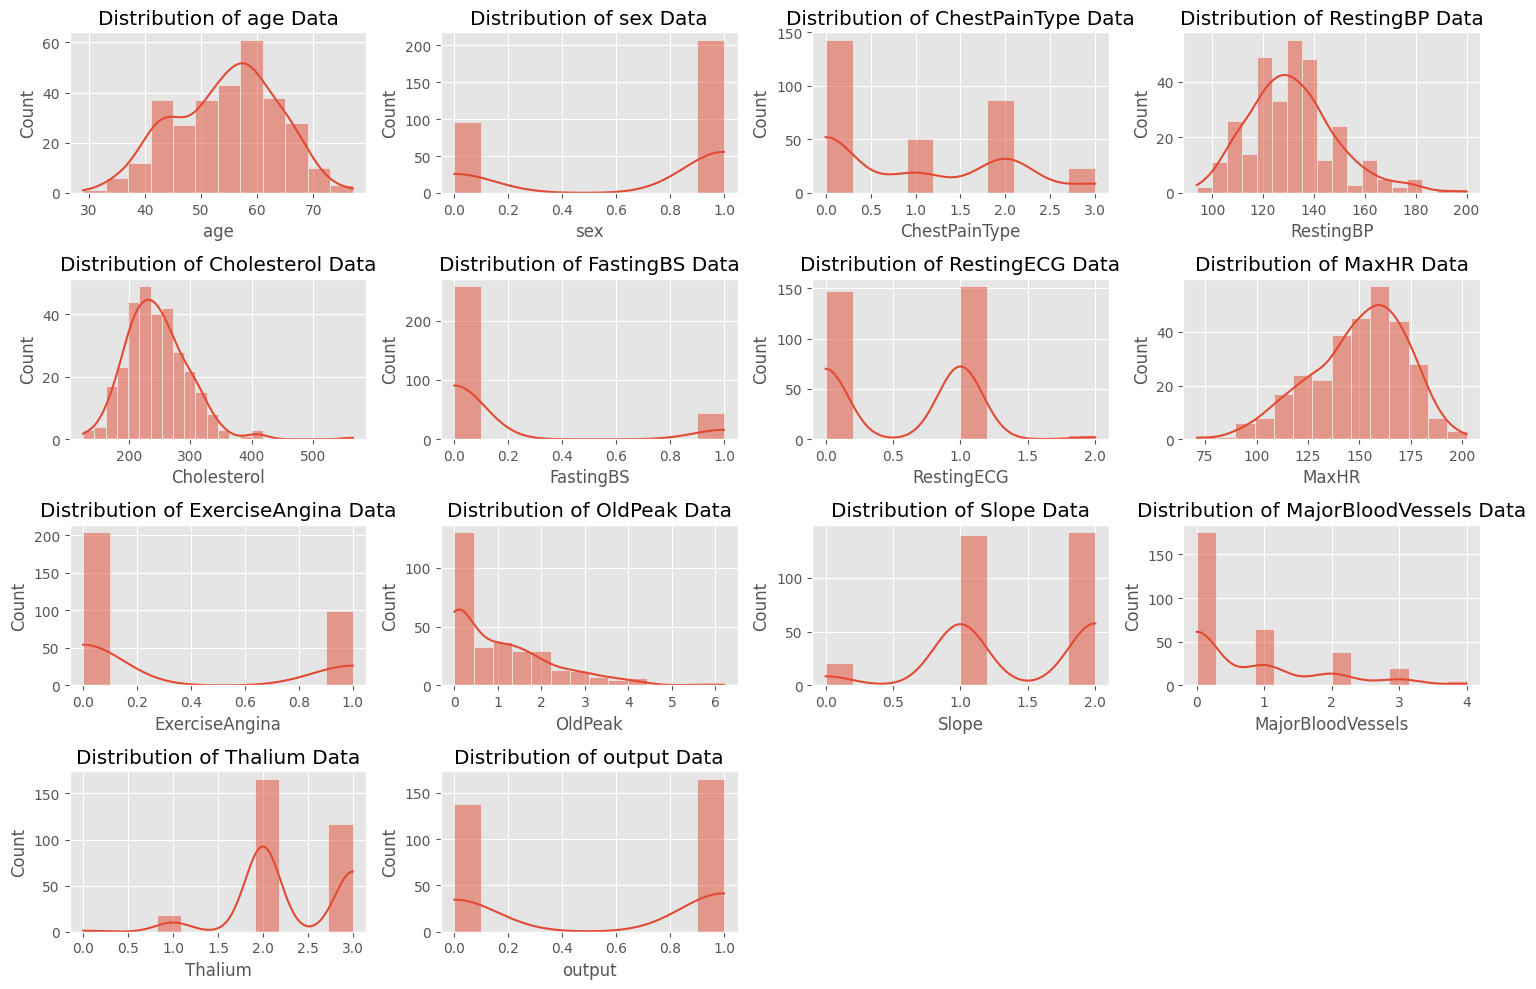

In [260]:
# Prove the above statement
print("Types of each column")
print(df.dtypes)
print("\n\nShape of the dataset")
print(df.describe().T)
print("\n\nChecking for null values")
print(df.isnull().sum())

plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

## 1. Model Construction

In [261]:
# Creating list of column names
column_names=df.columns.to_list()
column_names.remove('output')
column_names

# Getting input and output values
target = "output"
output=df[target]
input=df.drop(target,axis=1)

# verify that the classification is binary
output.value_counts()

output
1    165
0    138
Name: count, dtype: int64

### Training
Using the random forest classifer as listed in the assignment. THe following section completes step 1 of the assignment.

In [262]:
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)
rf.fit(X_train[column_names],y_train)

RandomForestClassifier()

## 2. Model Evaluation 

In [263]:
y_pred=rf.predict(X_test[column_names])
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

roc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc)


Confusion Matrix:
[[24  5]
 [ 6 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Accuracy: 0.819672131147541
Precision: 0.8387096774193549
Recall: 0.8125
ROC AUC Score: 0.8200431034482759


### Feature Importance
I am adding a printout of the feature_importance_ because this attribute returns an array of importance scores for each feature (input variable) used in the model. I find it interesting to compare the shap values to it.

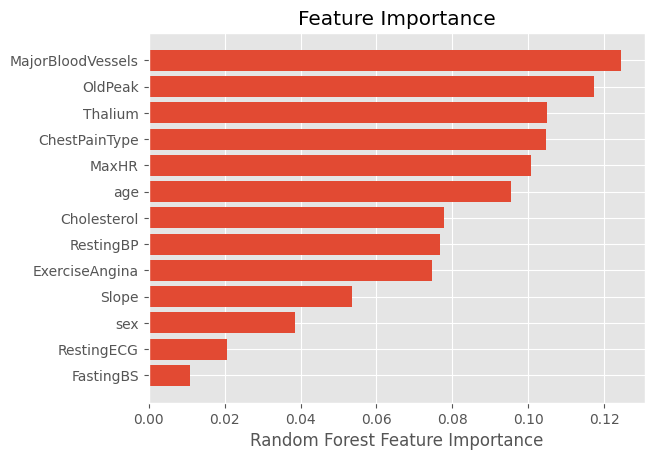

In [264]:
## Checking Feature importance 
importance = rf.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[column_names[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## 3. Apply SHAP and Interpret SHAP values
In this section I create all the required variables for the 5 plots

In [293]:
# Calculate SHAP values
explainer = shap.TreeExplainer(rf)

# Shape values 
shap_values = explainer.shap_values(X_test)

# Explainer object used in the waterfall plot
# temporary_shape_values is not really needed, but it is easy to create the explainer object
# by making a new variable.
temporary_shape_values = explainer(X_test)
exp = shap.Explanation(temporary_shape_values.values[:,:,1], 
                  temporary_shape_values.base_values[:,1], 
                  data=X_test.values, 
                  feature_names=X_test.columns)
idx = 0

# Taking all the values from the 1st observation
# shap_values_0 = shap_values[...,0]
shap_values_1 = shap_values[...,1]
shap_values = shap_values_1


## 5. Visualizations
There is no step 4 for this assignment.

### Summary Plot
Sorts based on importance/impact on prediction. logOdds value on X axis. Every dot is a sample. Very red means that it has a big numerical value. blue means small numerical value. If far left then it means  causes output of 0, far right  causes output of 1. Purple means medium value.

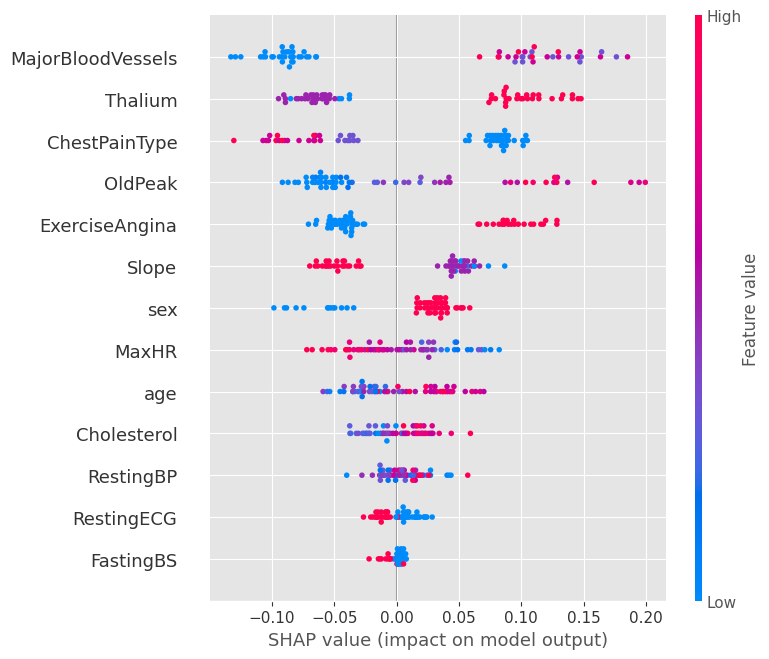

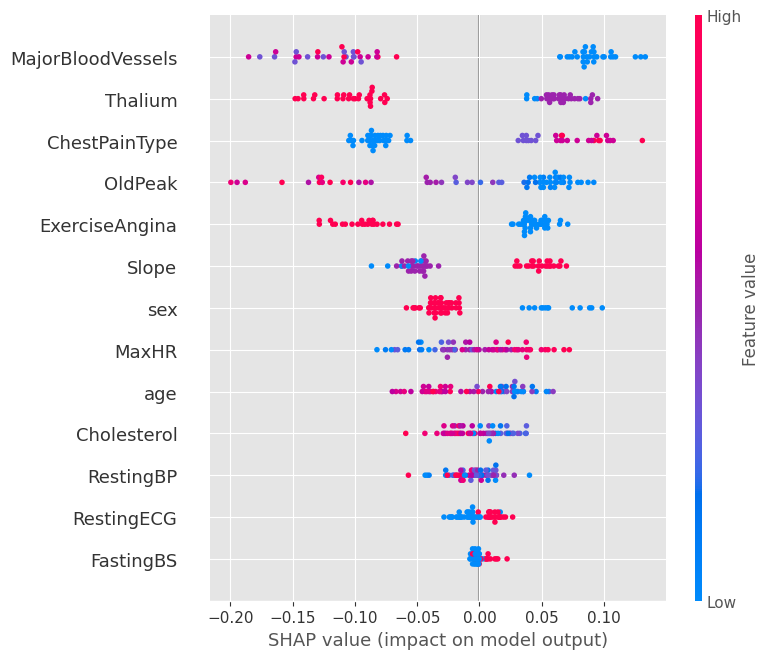

In [294]:
shap.summary_plot(shap_values, X_test)

### Force Plot
How a model makes decisions by showing how the features relate to each other. This is a series of force plots ordered together for comparision. The X axis is the value you are ordering by, the y axis is the shap values for that record. 
<br><br>
For example, if you set the X-axis drop down to Age the plot orders itself with the records with the lowest age to the left and increasing to the right.
<br>
if you then set the y-axis drop down to major blood vessels, you then can see the shap impact the feature had on each record.

In [289]:
shap.force_plot(explainer.expected_value[idx], shap_values, features=X_test,link="logit")

### Dependence Plot
A SHAP dependence plot helps you understand how a single feature affects the output of the model. A scatter plot for a single feature.

In [300]:
for i, col in enumerate(column_names, 1):
    shap.dependence_plot(f"{col}", shap_values, X_test, show=False)
    plt.title(f"Feature Dependence Plot of {col}")
    plt.tight_layout()
    plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 6

### Waterfall Plot
E[f(x)] is the average predicted heart attact for testd people. f(x) is the predicted value for this person. The values on the y axis are the feature values for this person. The values on the plot show how much each value changes the prediction
log odds.

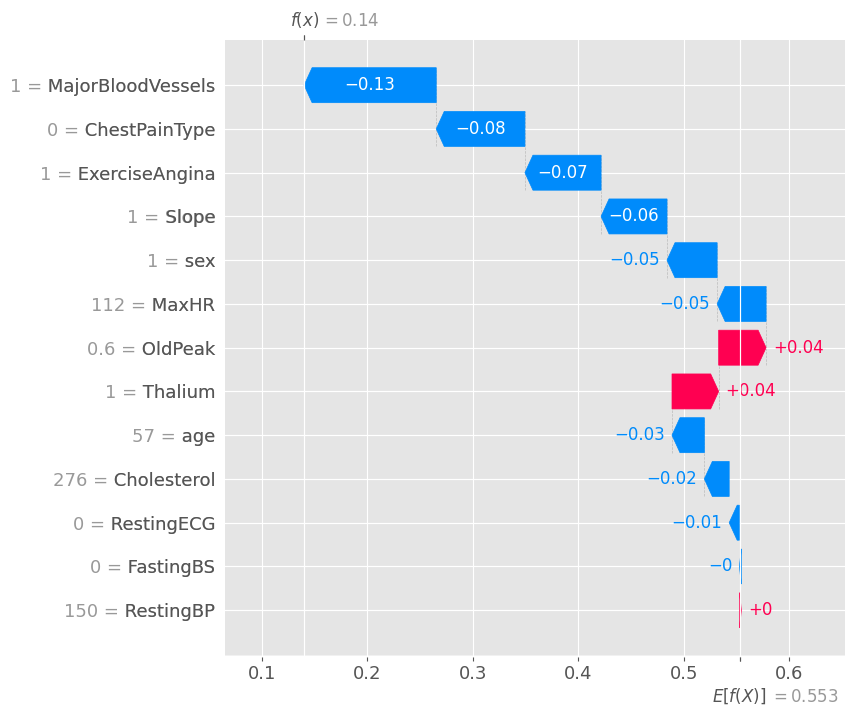

In [291]:
shap.waterfall_plot(exp[idx], max_display=len(column_names)+1)

### Decision Plot

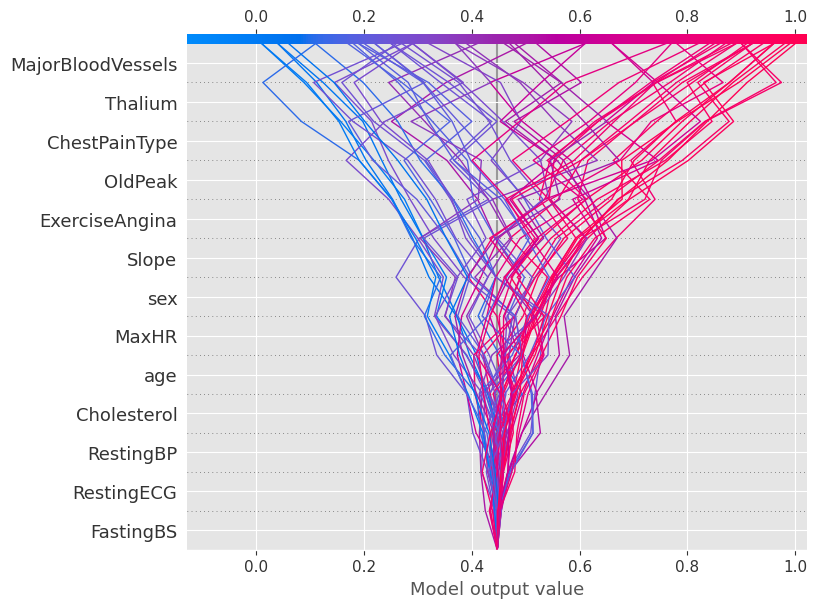

In [292]:
shap.decision_plot(explainer.expected_value[idx], shap_values, features=X_test)

## Summary

Force


Summary
Sorts based on importance/impact on prediction. logOdds value on X axis. Every dot is a sample. Very red means that it has a big numerical value. blue means small numerical value. If far left then it means  causes output of 0, far right  causes output of 1. Purple means medium value.

Waterfall
E[f(x)] is the average predicted heart attact for testd people. f(x) is the predicted value for this person. The values on the y axis are the feature values for this person. The values on the plot show how much each value changes the prediction
log odds.